### Exploring data augmentation and classic image segmentation methods
### Ming Ong

#### Import necessary libraries

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import re
import random

#### Set paths for images, assumes segmentation folder is in same directory

In [114]:
folder_dir = 'USA_segmentation'
masks_dir = 'masks'
nrg_dir = 'NRG_images'
rgb_dir = 'RGB_images'
pwd = Path('.')
rgb_images_dir = pwd / folder_dir / rgb_dir
nrg_images_dir = pwd / folder_dir / nrg_dir
mask_images_dir = pwd / folder_dir / masks_dir


#### Select a random image and plot its RGB/NRG/mask side-by-side

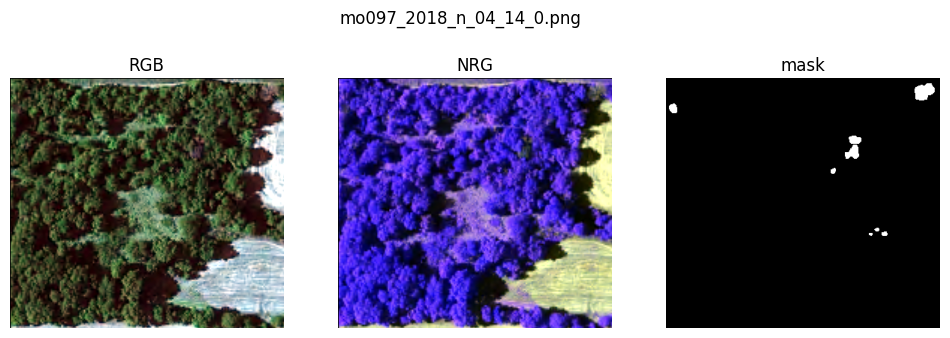

In [149]:
filename = str(random.sample(list(rgb_images_dir.iterdir()), 1)[0])
match = re.search(r'[^\/]*$', filename)
if match:
    rgb_filename = match.group(0)
    match2 = re.search(r'(?:^[^_]*_)(.*)', rgb_filename)
    if match2:
        base_filename = match2.group(1)
        nrg_filename = 'NRG_' + base_filename
        mask_filename = 'mask_' + base_filename
        # print(mask_filename, nrg_filename, rgb_filename, sep='\n')

        rgb_image = cv2.imread(str(rgb_images_dir/rgb_filename))
        nrg_image = cv2.imread(str(nrg_images_dir/nrg_filename))
        mask_image = cv2.imread(str(mask_images_dir/mask_filename))

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
        fig.suptitle(base_filename)

        axes[0].imshow(rgb_image)
        axes[0].axis('off')
        axes[0].set_title('RGB')

        axes[1].imshow(nrg_image)
        axes[1].axis('off')
        axes[1].set_title('NRG')

        axes[2].set_title('mask')
        axes[2].imshow(mask_image)
        axes[2].axis('off')

        # fig.tight_layout()